In [ ]:
from google.colab import files
uploaded = files.upload()

Saving opere.zip to opere.zip


In [ ]:
# Importa le librerie
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.cluster import KMeans
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import zipfile

In [ ]:
zip_path = "opere.zip"
extract_path = "opere"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Cartella opere estratta correttamente.")

IMAGE_DIR = "./opere/opere"
TARGET_SIZE = (224, 224)

print("📸 File trovati nella cartella opere:")
print(os.listdir(IMAGE_DIR)[:5])


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

def extract_features(img_path, model):
    try:
        img = Image.open(img_path).resize(TARGET_SIZE)
        img_array = np.array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        features = model.predict(img_array, verbose=0)
        features = features.mean(axis=(1, 2)).flatten()
        return features
    except Exception as e:
        print(f"Errore con {img_path}: {e}")
        return None


In [ ]:
if os.path.exists("feature_matrix.npy"):
    feature_matrix = np.load("feature_matrix.npy")
    print("✅ Feature caricate:", feature_matrix.shape)
    image_filenames = os.listdir(IMAGE_DIR)
else:
    print("⚠️ Nessun file .npy trovato, verranno rielaborate le immagini...")

    all_features = []
    image_filenames = []

    print("Inizio estrazione delle feature...")

    counter = 0
    for filename in os.listdir(IMAGE_DIR):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(IMAGE_DIR, filename)
            features = extract_features(file_path, model)
            if features is not None:
                all_features.append(features)
                image_filenames.append(filename)
                counter += 1
                if counter % 100 == 0:
                    print(f"{counter} immagini elaborate...")

    feature_matrix = np.array(all_features)
    np.save("feature_matrix.npy", feature_matrix)
    print(f"\n✅ Estrazione completata: {len(image_filenames)} immagini.")
    print(f"✅ Dimensione matrice delle feature: {feature_matrix.shape}")


In [ ]:
K = 5  # Numero di cluster
print(f"Inizio clustering con K = {K}...")

kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(feature_matrix)

print("Clustering completato.")

# Salva i risultati in un file CSV
results_df = pd.DataFrame({
    'Filename': image_filenames,
    'Cluster': cluster_labels
})
results_df.to_csv("cluster_results.csv", index=False)
print("✅ Risultati salvati in cluster_results.csv")


Inizio clustering con K = 5...
Clustering completato.
✅ Risultati salvati in cluster_results.csv


Distribuzione dei cluster:
Cluster
2    318
4    216
1    199
3    139
0    128
Name: count, dtype: int64


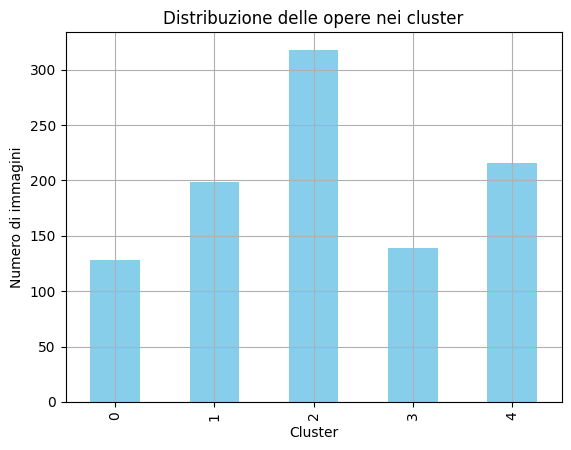

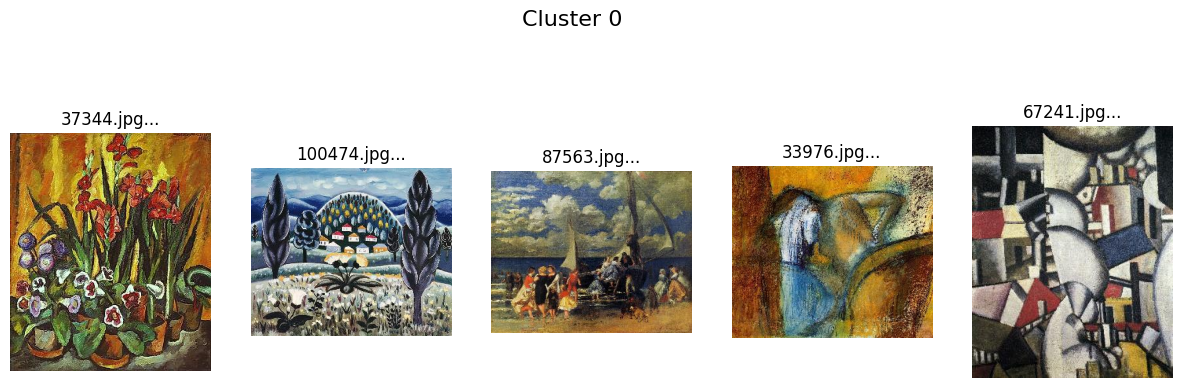

In [ ]:
print("Distribuzione dei cluster:")
print(results_df['Cluster'].value_counts())

# 📊 Visualizzazione della distribuzione dei cluster
results_df['Cluster'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("Distribuzione delle opere nei cluster")
plt.xlabel("Cluster")
plt.ylabel("Numero di immagini")
plt.grid(True)
plt.show()


In [ ]:
# Visualizza le prime 5 immagini di un cluster
cluster_id_to_show = 0
cluster_images = results_df[results_df['Cluster'] == cluster_id_to_show]['Filename'].tolist()

fig, axes = plt.subplots(1, min(5, len(cluster_images)), figsize=(15, 5))
fig.suptitle(f"Cluster {cluster_id_to_show}", fontsize=16)

for i, filename in enumerate(cluster_images[:5]):
    img_path = os.path.join(IMAGE_DIR, filename)
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].set_title(filename[:15] + '...')
    axes[i].axis('off')

plt.show()

In [ ]:
# Seleziona un cluster
cluster_id = 0

# Prendi le prime due immagini di quel cluster
selected_images = results_df[results_df['Cluster'] == cluster_id]['Filename'].tolist()[:2]

# Percorsi completi
img1_path = os.path.join(IMAGE_DIR, selected_images[0])
img2_path = os.path.join(IMAGE_DIR, selected_images[1])


In [ ]:
!pip install lime

from lime import lime_image
from skimage.segmentation import mark_boundaries

# Inizializza LIME per immagini
explainer = lime_image.LimeImageExplainer()

def predict_fn(images):
    images = preprocess_input(images)
    preds = model.predict(images)
    # Simuliamo una classificazione fittizia sommando le feature
    return np.array([np.sum(p) for p in preds]).reshape(-1, 1)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=69c704a8aafe5222697921b5c4f0e6ab131943bbe1ceca14e0f07b2b512779d8
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
lime_filename = f"lime_explanation_{selected_images[0]}.png"

if os.path.exists(lime_filename):
    print("✅ Mappa LIME già salvata, la carico...")
    img = Image.open(lime_filename)
    plt.imshow(img)
    plt.title(f"Mappa LIME caricata ({selected_images[0]})")
    plt.axis('off')
    plt.show()
else:
    print("⚠️ Nessuna mappa LIME trovata, verrà generata...")

    # Carica l'immagine originale
    img = imread(img1_path)

    # Applica LIME
    explanation = explainer.explain_instance(
        img, predict_fn, top_labels=1, hide_color=0, num_samples=1000
    )

    # Ottieni la mappa
    temp, mask = explanation.get_image_and_mask(
        label=explanation.top_labels[0],
        positive_only=True,
        hide_rest=False,
        num_features=5,
        min_weight=0.1
    )

    # Visualizza
    plt.imshow(mark_boundaries(temp, mask))
    plt.title(f"Zone rilevanti in {selected_images[0]}")
    plt.axis('off')
    plt.show()

    # Salva la mappa
    plt.imsave(lime_filename, mark_boundaries(temp, mask))
    print(f"✅ Mappa LIME salvata come {lime_filename}")

⚠️ Nessuna mappa LIME trovata per la seconda immagine, verrà generata...


  0%|          | 0/300 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 

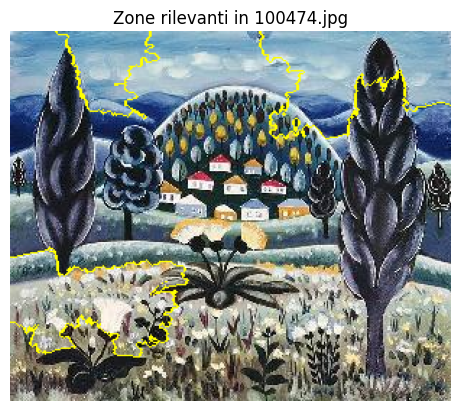

✅ Mappa LIME salvata come lime_explanation_100474.jpg.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
lime_filename_2 = f"lime_explanation_{selected_images[1]}.png"

if os.path.exists(lime_filename_2):
    print("✅ Mappa LIME già salvata, la carico...")
    img = Image.open(lime_filename_2)
    plt.imshow(img)
    plt.title(f"Mappa LIME caricata ({selected_images[1]})")
    plt.axis('off')
    plt.show()
else:
    print("⚠️ Nessuna mappa LIME trovata per la seconda immagine, verrà generata...")

    # Carica l'immagine originale
    img = imread(img2_path)

    # Applica LIME
    explanation = explainer.explain_instance(
        img, predict_fn, top_labels=1, hide_color=0, num_samples=1000
    )

    # Ottieni la mappa
    temp, mask = explanation.get_image_and_mask(
        label=explanation.top_labels[0],
        positive_only=True,
        hide_rest=False,
        num_features=5,
        min_weight=0.1
    )

    # Visualizza
    plt.imshow(mark_boundaries(temp, mask))
    plt.title(f"Zone rilevanti in {selected_images[1]}")
    plt.axis('off')
    plt.show()

    # Salva la mappa
    plt.imsave(lime_filename_2, mark_boundaries(temp, mask))
    print(f"✅ Mappa LIME salvata come {lime_filename_2}")